In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from sympy.printing.pretty.pretty_symbology import line_width

from nds_toolbox.preprocessing.features import compute_wavelet

import seaborn as sns



FIG_WIDTH = 7.5
MY_FONT_SIZE = 9


plt.rcParams.update({
    # --- Fonts ---
    "font.family": "Arial",
    "font.size": MY_FONT_SIZE,

    # --- Legend ---
    "legend.fontsize": MY_FONT_SIZE,
    "legend.frameon": False,

    # --- Titles ---
    "figure.titlesize": MY_FONT_SIZE,
    "axes.titleweight": "normal",
    "axes.titlesize": MY_FONT_SIZE,

    # --- Axes ---
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.unicode_minus": True,
    "axes.labelsize": MY_FONT_SIZE,

    # --- Lines & markers ---
    "lines.linewidth": 1.0,
    "lines.markersize": 0.7,

    # --- Ticks ---
    "xtick.labelsize": MY_FONT_SIZE,
    "ytick.labelsize": MY_FONT_SIZE,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,
    "axes.linewidth": 0.7,
    "xtick.minor.visible": False,
    "ytick.minor.visible": False,
    "xtick.major.width": 0.6,
    "ytick.major.width": 0.6,

    # Grid
    "axes.grid": False,
    "grid.linestyle": ":",
    "grid.linewidth": 0.5,
    "grid.alpha": 0.5,


    # --- Layout ---
    "figure.autolayout": True,

    # --- DPI ---
    "savefig.dpi": 900,
    "figure.dpi": 200,
})


# Load the data and model result

In [23]:

signal_dir = "../data/CTF_rest"
files = [f"{signal_dir}/bursts/subject{i:02d}.npy" for i in range(65)]
data_all = [np.load(f, allow_pickle=True) for f in files]


fs = 100
seed = 2025

[ 3 11 22 34 42 63]
[ 5.5 11.  17.  21.  31.5]


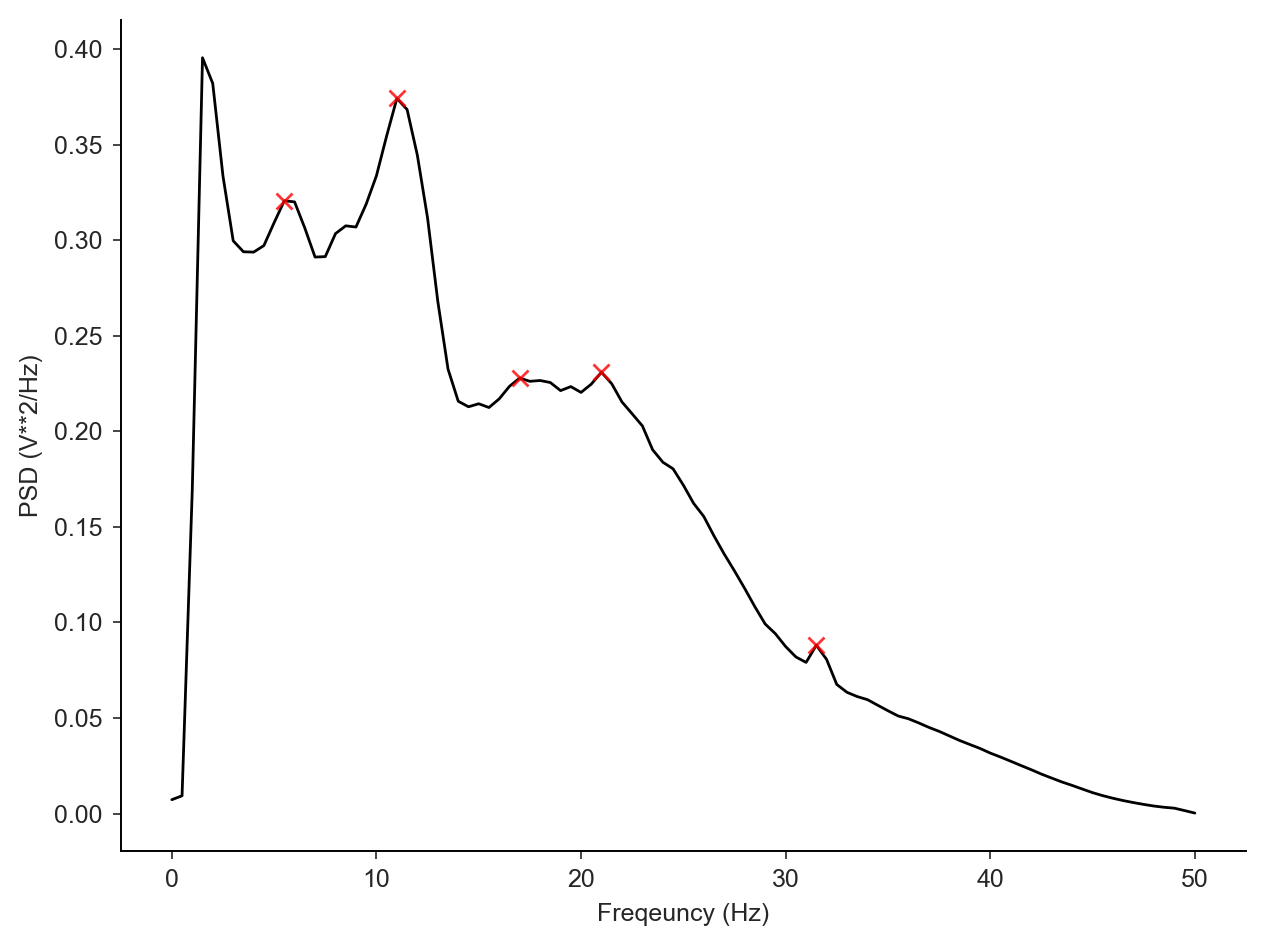

In [24]:
from scipy.signal import welch
import matplotlib.pyplot as plt
psd_sample = []
for data in data_all:
    f, psd = welch(data.T, fs, scaling="density", average="mean",nperseg=fs * 2)
    psd_sample.append(psd)

psd_sample = np.array(psd_sample)  # (65, 1, 51)
mean_psd = np.mean(psd_sample, axis=0)[0]

from scipy.signal import find_peaks
distance_bins = int(4/(f[1] - f[0]))
peaks, _ = find_peaks(mean_psd, distance= distance_bins)

print(peaks)
peaks = peaks[1:] #manually remove 2 hz
print(f[peaks])


plt.plot(f, mean_psd, "k")
plt.plot(f[peaks], mean_psd[peaks], "rx", ms = 6, alpha = 0.8)

plt.xlabel("Freqeuncy (Hz)")
plt.ylabel("PSD (V**2/Hz)")
plt.show()

In [25]:
signal = np.concatenate(data_all)
signal = (signal - np.mean(signal)) / np.std(signal) #standarize the signal
signal = signal[:, 0]


from nds_toolbox.preprocessing.features import choose_embedding_dim

num_emb = choose_embedding_dim(np.mean(f[peaks]), fs, min_cycles = 2.5, ensure_odd = True)

print("num_embeddings", num_emb) #15 emb







#alpha will be bayesian estimated, but to roughly estimate num_states beforehand, i set it to 1 (uniform stickbreaking beta distribution)
num_states = int(np.ceil(np.log(len(signal)))) # E[K] = a ln n
print("num_states: ", num_states)
# this sets K above the expected occupied clusters
#15 states

Chosen window size = 0.145 (sec): minimum cycles of 2.5 at 17.2 Hz
Chosen embedding dimension = 15: sampling rate = 100 Hz
num_embeddings 15
num_states:  15


In [26]:
len(signal), np.log(len(signal))

(1929832, np.float64(14.472943510460166))

In [27]:
from nds_toolbox.preprocessing.features import (compute_tde,trim_data)
tde_signal = compute_tde(signal, num_emb)



trimmed_signal = trim_data(signal, num_embeddings = num_emb, verbose = False)
trimmed_time_vec = np.linspace(0, len(trimmed_signal)/fs, len(trimmed_signal))

7 data points were lost from both ends.
data shape: (1929818, 15)


## load the model result

In [75]:
import pickle
performance_dir = "../data/CTF_rest"
load_path = os.path.join(performance_dir, "CTF_rest_HMM_result.pkl")

with open(load_path, "rb") as f:
    res = pickle.load(f)

df_list = [pd.DataFrame(r) for r in res]
df = pd.concat(df_list, axis = 0, ignore_index = True)

df.head()

,method,signal,true_states,burst_f,fs,snr,est_params,best_model_id,loss_best,loss_all,fit_t,pred_t,total_time,num_states,num_emb,est_states,order,summary_stats,mcc,loss
0,HMM,"[-0.7449765, 0.003586299, 0.553737, 0.00757364...",None,None,100,None,"{'initial_probs': [0.15063845, 0.18212779, 0.1...",6,1.104244,"[[1.4622262470929286, 1.417026020544128, 1.465...",68.947407,0.440387,69.387794,7,15,"[1, 3, 1, 3, 1, 3, 1, 3, 1, 2, 2, 2, 0, 0, 0, ...","[5, 0, 6, 1, 2, 3, 4]",{'fractional_occupancies': [0.1605275730664757...,None,1.104244
1,HMM (Imputed),"[-0.7449765, 0.003586299, 0.553737, 0.00757364...",None,None,100,None,"{'initial_probs': [0.15063845, 0.18212779, 0.1...",6,1.104244,"[[1.4622262470929286, 1.417026020544128, 1.465...",68.947407,0.440387,69.387794,7,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 0, 6, 1, 2, 3, 4]",{'fractional_occupancies': [0.2382488918644141...,None,1.104244


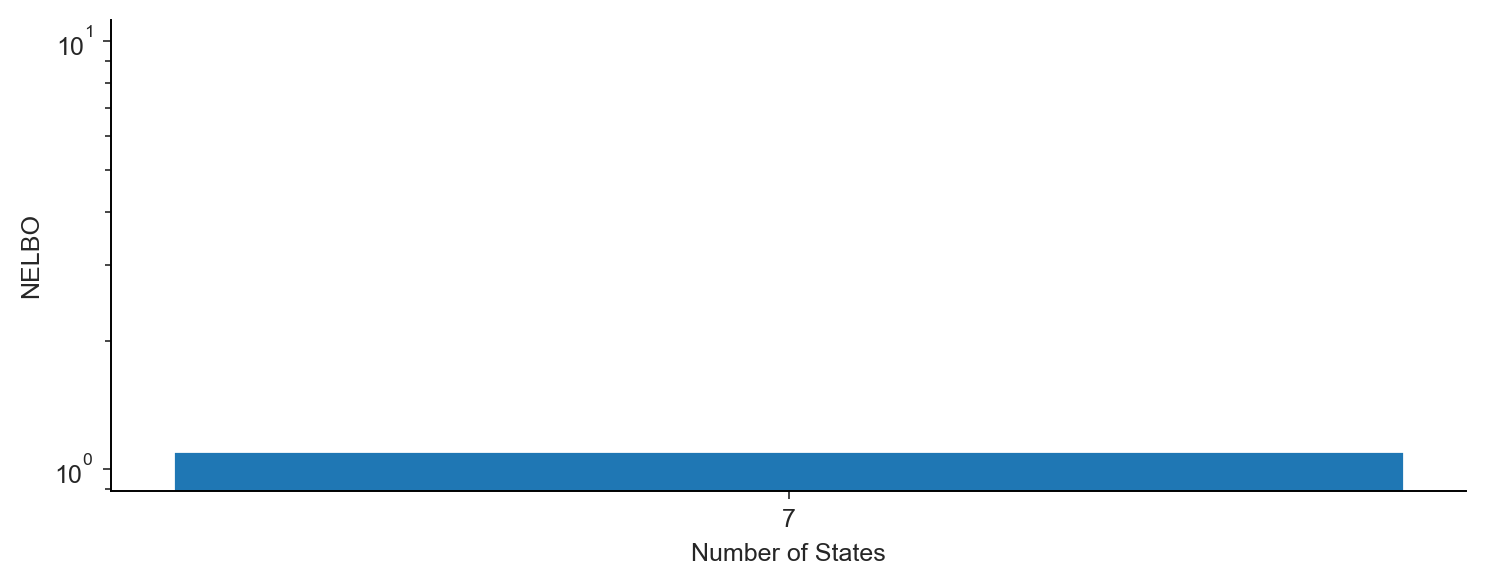

In [86]:
hmm_res = df.query("method == 'HMM'")
num_states_vec = hmm_res.num_states.to_numpy().astype(int)


hmm_color   = "#1f77b4"



elbos = hmm_res["loss_best"]
fig, ax = plt.subplots(figsize = (FIG_WIDTH, 3))
ax.bar(num_states_vec, elbos, color = hmm_color, width = 1, align = "center")
ax.set_yscale("log")
ax.set_xticks(num_states_vec)
ax.set_ylabel("NELBO")
ax.set_xlabel("Number of States")


fig.savefig(
    f"../figures/CTF_rest_HMM_nelbo.jpg",
    bbox_inches="tight")






## 7 states

In [87]:
num_states = 7
res7 = hmm_res.query("num_states == 7")



est_states = res7.est_states.to_numpy()[0]
initial_probs, transition_probs, means, covs, stationary_dist = res7.est_params.values[0].values()

est_states_onehot = np.eye(num_states)[est_states]



summary_stats = res7.summary_stats.values[0]
fo = summary_stats["fractional_occupancies"]
lifetimes = summary_stats["lifetimes"]
median_lifetimes = summary_stats["median_lt_states"]
CV_intervals = summary_stats["CV_intervals"]
burst_rates = summary_stats["burst_rates"]
powers = summary_stats["powers"]
spectra = summary_stats["spectra"]
f_vec, psd_vec = summary_stats["spectra"]



In [88]:
fo

array([0.16052757, 0.15443529, 0.13728497, 0.14823833, 0.17271525,
       0.12226697, 0.10453162])

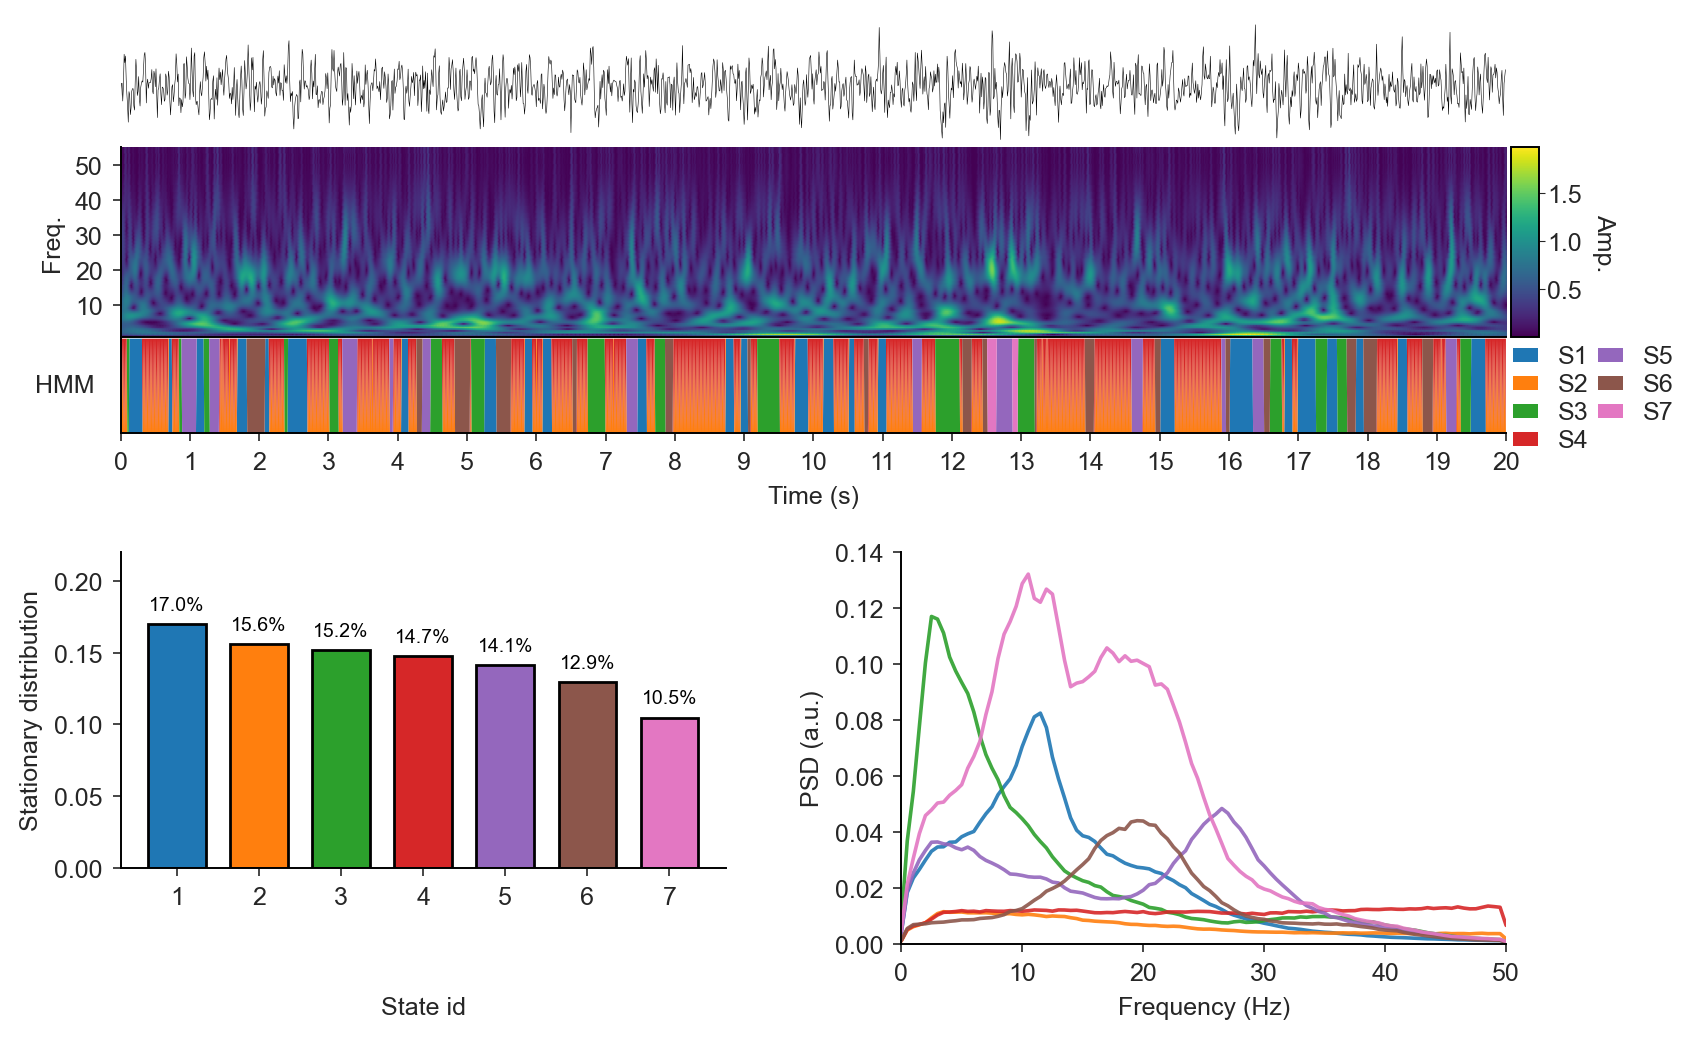

In [92]:

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(num_states+1)]
colors = colors


state_labels = [f"S{i+1}" for i in range(num_states)]

start_t = 0
plot_t = 20



t, f, amp = compute_wavelet(trimmed_signal[start_t*fs:plot_t*fs], fs, f_min = 1, f_max = 80, df = 0.5, wavelet = "cmor1.5-1.0")
t += start_t

mosaic = [["a1", "a1"],
          ["a2", "a2"],
          ["a3", "a3"],
          ["gap", "gap"],
          ["b", "c"],
          ["d", "c"],
         ]

fig, axes = plt.subplot_mosaic(
    mosaic,
    figsize=(FIG_WIDTH, 5.),  # a hair taller
    constrained_layout=True,
    gridspec_kw={"height_ratios":[0.4,0.6,0.3, 0.1 ,1., 0.1],
                "width_ratios":[0.5,0.5]}
)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0., hspace=0.01)
axes["gap"].set_visible(False)


axes["a1"].plot(trimmed_time_vec[start_t*fs:plot_t*fs], trimmed_signal[start_t*fs:plot_t*fs], lw=0.2, color="k")
axes["a1"].set_frame_on(False)
#axes["a1"].set_title(f"Raw signal (SNR = {snr_db} dB)",pad= 0.3)
axes["a1"].sharex(axes["a3"])
axes["a1"].set_yticks([])
axes["a1"].set_xticks([])





#axes["b1"].set_ylabel(f"{plot_f}Hz", fontsize = TINY_SIZE, rotation = 0, labelpad = 20)

for s in ("top","right","bottom","left"):
    axes["a1"].spines[s].set_visible(False)
axes["a1"].set_frame_on(False)
axes["a1"].tick_params(axis='both', which='both',
                       bottom=False, top=False, left=False, right=False,
                       labelbottom=False, labelleft=False)





im = axes["a2"].imshow(
    amp, extent=[t[0], t[-1], f[0], f[-1]],
    origin="lower", aspect="auto", cmap="viridis",
    vmin=amp.min(), vmax=amp.max()
)
axes["a2"].set_ylabel("Freq.")
#axes["a2"].set_title("Wavelet Transform",pad = 0.3)


axes["a2"].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=False)
axes["a2"].yaxis.set_major_locator(MultipleLocator(10))

axes["a2"].set_ylim(1, 55)
#axes["a2"].sharex(axes["a1"])


cax = inset_axes(
    axes["a2"],              # parent axis
    width="2%",              # width as percentage of a2
    height="100%",           # match the height
    loc="center right",      # position inside a2
    borderpad=-1.3             # negative value moves it outside slightly
)

# Add the colorbar to the inset axis
cb = fig.colorbar(im, cax=cax)
cb.set_label("Amp.", rotation = 270, labelpad = 12)
cb.ax.tick_params(which="both", length=2, width=0.4, pad=1)



axes["a3"].stackplot(trimmed_time_vec[start_t*fs:plot_t*fs], est_states_onehot[start_t*fs:plot_t*fs].T, linewidth = 0, colors = colors, labels = state_labels)
axes["a3"].set_ylabel(f"HMM", rotation = 0, labelpad=20, va="center")
#axes["a3"].sharex(axes["a4"])


for key in ["a1", "a2"]:
    axes[key].tick_params(axis="x", which="both", bottom=False, labelbottom=False)

from matplotlib.ticker import MultipleLocator
axes["a3"].xaxis.set_major_locator(MultipleLocator(1.0))






axes["a3"].set_xlabel("Time (s)")

#axes["a4"].xaxis.set_major_locator(MultipleLocator(1.0))
#axes["a5"].xaxis.set_minor_locator(MultipleLocator(0.5))
#axes["a5"].tick_params(axis='x', which='both', bottom=True, labelbottom=True, length = 0)
axes["a3"].tick_params(axis='y', which='both', left=False, labelleft=False)
axes["a3"].set_ylim(0, 1)
axes["a3"].set_xlim(start_t, plot_t)


axes["a3"].spines["bottom"].set_visible(True)   # keep x-axis frame




handles, labels = axes["a3"].get_legend_handles_labels()

fig.legend(handles, labels,
           loc="center left",          # anchor to left of the bbox
           bbox_to_anchor=(0.98, 0.62), # (x, y) in figure coordinates
           frameon=False,
           handlelength=1,
           handleheight=0.5,
           labelspacing = 0.2,
           ncol = 2,
           columnspacing = 0.4,
           )





for k, w in enumerate(stationary_dist):
    axes["b"].bar(k, w, width = 0.7, color = colors[k], zorder = 1, align = "center", edgecolor = "k")
    axes["b"].text(k, w + 0.01,"%.1f%%" % (w * 100.0), horizontalalignment="center", color = "k" , fontsize = MY_FONT_SIZE - 2 )
    axes["b"].set_ylabel("Stationary distribution")
    axes["b"].set_xticks(np.arange(num_states), labels = np.arange(1, num_states + 1))
    axes["b"].tick_params(axis='y')


    axes["b"].set_ylim(0, 0.22)




for i in range(num_states):

    axes["c"].plot(f_vec[i], psd_vec[i], color = colors[i], lw = 1.3, alpha = 0.9)
    axes["c"].set_xlim(0, 50)
    axes["c"].set_xlabel("Frequency (Hz)")
    axes["c"].set_ylabel("PSD (a.u.)")
    axes["c"].set_ylim(0, 0.14)
    #ab_c.tick_params(axis="both", which="both", bottom = False, top = False, left = False, right = False)
    #ab_c.grid(False)




axes["d"].set_xticks([])
axes["d"].set_yticks([])
axes["d"].spines[:].set_visible(False)
axes["d"].set_xlabel("State id")
fig.align_xlabels([axes["c"], axes["d"]])





#fig.align_ylabels([axes["a3"], axes["a4"]])




fig.savefig(
    f"../figures/CTF_rest_HMM_{num_states}.jpg",
    bbox_inches="tight")


plt.show()





/var/folders/5z/yggynsqj6632pbql_bb3kqm40000gn/T/ipykernel_21545/2568334019.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


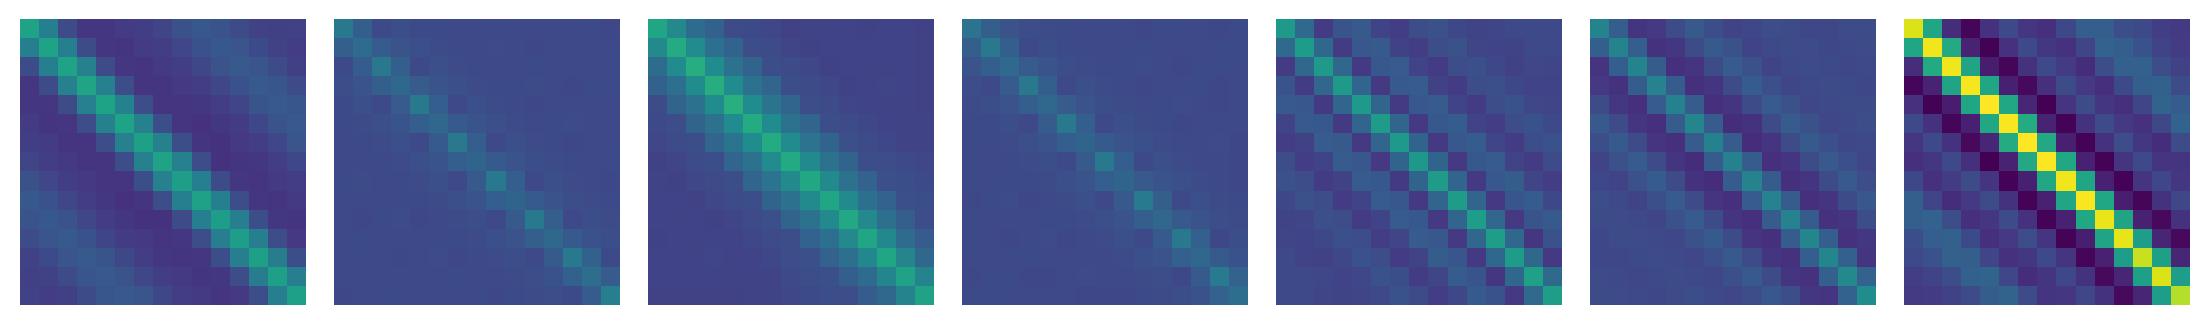

In [90]:
# shared normalization

vmin  = np.min(covs)               # global minimum
vmax  = np.max(covs)               # global maximum
norm  = plt.Normalize(vmin, vmax)      # shared normalisation


fig, ax = plt.subplots(1, covs.shape[0], figsize = (covs.shape[0]*2, 2), gridspec_kw = {"wspace":0.1})
for i ,cov in enumerate(covs):
    ax[i].imshow(cov, norm = norm, cmap = "viridis")
    ax[i].set_axis_off()

fig.savefig(
    f"../figures/CTF_rest_HMM_{num_states}_covs.jpg",
    bbox_inches="tight")